#### __05. 서포트 벡터 머신__

__5.1 선형 SVM 분류__

Large Margin Classification이라고도 한다.
결정 경계는 이 위에 위치한 샘플에 의해 결정되고, 이를 서포트 벡터라고 한다.

In [1]:
'''
샘플이 경계의 중간이나 바깥쪽에 있는 경우(마진 오류)에 대한 균형을 잡는 것을 소프트 마진 분류라고함
'''
import sklearn
import numpy as np
np.random.seed(42)
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC


iris = datasets.load_iris()
X = iris["data"][:, (2, 3)]  # 특성: 꽃잎 길이, 꽃잎 너비
y = (iris["target"] == 2).astype(np.float64)  # 타깃: 버지니카 품종 여부

svm_clf = Pipeline([
    ("scaler", StandardScaler()),
    ("linear_svc", LinearSVC(C=1, loss="hinge", random_state=42)),
])

svm_clf.fit(X, y)

Pipeline(steps=[('scaler', StandardScaler()),
                ('linear_svc', LinearSVC(C=1, loss='hinge', random_state=42))])

In [2]:
svm_clf.predict([[5.5, 1.7]])  # [5.5, 1.7] 특성을 갖는 붓꽃에 대한 예측은 양성, 버지니카 품종

array([1.])

In [3]:
# 규제 C에 선형적으로 반비례하여 규제 강도가 정해진다
# 즉 C=float("inf"), 무한대이면 마진을 전혀 허용하지 않는 하드 마진 분류 모델이 된다.

svm_clf1 = LinearSVC(C=1, loss="hinge", random_state=42)
svm_clf2 = LinearSVC(C=100, loss="hinge", random_state=42)

scaler = StandardScaler()

scaled_svm_clf1 = Pipeline([
    ("scaler", scaler),
    ("linear_svc", svm_clf1),
])

scaled_svm_clf2 = Pipeline([
    ("scaler", scaler),
    ("linear_svc", svm_clf2)
])

scaled_svm_clf1.fit(X, y)
scaled_svm_clf2.fit(X, y)

c:\Users\Kang MinJae\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Pipeline(steps=[('scaler', StandardScaler()),
                ('linear_svc',
                 LinearSVC(C=100, loss='hinge', random_state=42))])

In [4]:
b1 = svm_clf1.decision_function([-scaler.mean_ / scaler.scale_])
b2 = svm_clf2.decision_function([-scaler.mean_ / scaler.scale_])
w1 = svm_clf1.coef_[0] / scaler.scale_
w2 = svm_clf2.coef_[0] / scaler.scale_

svm_clf1.intercept_ = np.array([b1])
svm_clf2.intercept_ = np.array([b2])
svm_clf1.coef_ = np.array([w1])
svm_clf2.coef_ = np.array([w2])

t = y * 2 - 1
support_vectors_idx1 = (t * (X.dot(w1) + b1) < 1).ravel()
support_vectors_idx2 = (t * (X.dot(w2) + b2) < 1).ravel()
svm_clf1.support_vectors_ = X[support_vectors_idx1]
svm_clf2.support_vectors_ = X[support_vectors_idx1]

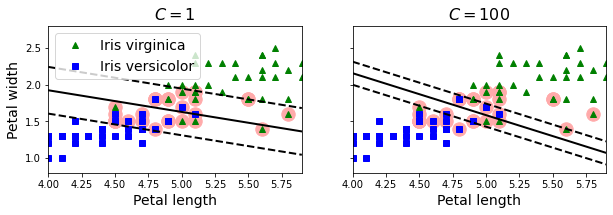

In [13]:
fig, axes = plt.subplots(ncols=2, figsize=(10,2.7), sharey=True)

def plot_svc_decision_boundary(svm_clf, xmin, xmax):
    w = svm_clf.coef_[0]            # 결정경계 파라미터(w0, w1)
    b = svm_clf.intercept_[0]       # 절편(b)

    # 결정경계에서 w0*x0 + w1*x1 + b = 0 이므로
    # => x1 = -w0/w1 * x0 - b/w1
    x0 = np.linspace(xmin, xmax, 200)
    decision_boundary = -w[0]/w[1] * x0 - b/w[1]    # 결정경계

    margin = 1/w[1]                                 # 마진(도로 폭)
    gutter_up = decision_boundary + margin          # 도로 경계(윗쪽)
    gutter_down = decision_boundary - margin        # 도로 경계(아랫쪽)

    # 서포트 벡터 표시
    svs = svm_clf.support_vectors_
    plt.scatter(svs[:, 0], svs[:, 1], s=180, facecolors='#FFAAAA')
    
    # 결정경계 및 도로 경계 그리기
    plt.plot(x0, decision_boundary, "k-", linewidth=2)
    plt.plot(x0, gutter_up, "k--", linewidth=2)
    plt.plot(x0, gutter_down, "k--", linewidth=2)

# 왼편 그림: svm_clf1 모델
plt.sca(axes[0])
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "g^", label="Iris virginica")
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "bs", label="Iris versicolor")
plot_svc_decision_boundary(svm_clf1, 4, 5.9)
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="upper left", fontsize=14)
plt.title("$C = {}$".format(svm_clf1.C), fontsize=16)
plt.axis([4, 5.9, 0.8, 2.8])

# 오른편 그림: svm_clf2 모델
plt.sca(axes[1])
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "g^")
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "bs")
plot_svc_decision_boundary(svm_clf2, 4, 5.99)
plt.xlabel("Petal length", fontsize=14)
plt.title("$C = {}$".format(svm_clf2.C), fontsize=16)
plt.axis([4, 5.9, 0.8, 2.8])

plt.show()

__5.2 비선형SVM 분류__


In [14]:
from sklearn.datasets import make_moons
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures

X, y = make_moons(n_samples=100, noise=0.15)
polynomial_svm_clf = Pipeline([
    ("poly_features", PolynomialFeatures(degree=3)),
    ("scaler", StandardScaler()),
    ("svm_clf", LinearSVC(C=10, loss="hinge"))
])

polynomial_svm_clf.fit(X, y)

c:\Users\Kang MinJae\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Pipeline(steps=[('poly_features', PolynomialFeatures(degree=3)),
                ('scaler', StandardScaler()),
                ('svm_clf', LinearSVC(C=10, loss='hinge'))])

In [15]:
def plot_dataset(X, y, axes):
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "bs")
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "g^")
    plt.axis(axes)
    plt.grid(True, which="both")
    plt.xlabel(r"$x_1$", fontsize=20)
    plt.ylabel(r"$x_2$", fontsize=20, rotation=0)

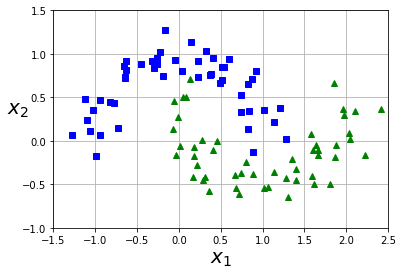

In [17]:
plot_dataset(X, y, [-1.5, 2.5, -1, 1.5])
plt.show()

In [28]:
def plot_predictions(clf, axes):
    x0s = np.linspace(axes[0], axes[1], 100)
    x1s = np.linspace(axes[2], axes[3], 100)
    x0, x1 = np.meshgrid(x0s, x1s)
    X = np.c_[x0.ravel(), x1.ravel()]

    y_pred = clf.predict(X).reshape(x0.shape)
    y_decision = clf.decision_function(X).reshape(x0.shape)
    plt.contourf(x0, x1, y_pred, cmap=plt.cm.brg, alpha=0.2)        # 결정경계 그리기
    plt.contourf(x0, x1, y_decision, cmap=plt.cm.brg, alpha=0.1)    # 등고선 그리기

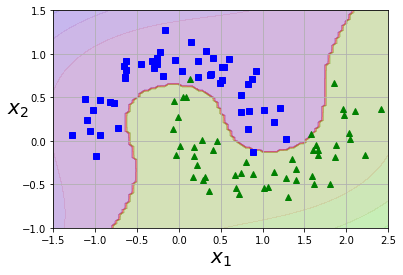

In [29]:
plot_predictions(polynomial_svm_clf, [-1.5, 2.5, -1, 1.5])
plot_dataset(X, y, [-1.5, 2.5, -1, 1.5])

plt.show()

In [30]:
# 다항식 커널
from sklearn.svm import SVC
poly_kernel_svm_clf = Pipeline([
    ("scaler", StandardScaler()),
    ("svm_clf", SVC(kernel="poly", degree=3, coef0=1, C=5))
])
poly_kernel_svm_clf.fit(X, y)

Pipeline(steps=[('scaler', StandardScaler()),
                ('svm_clf', SVC(C=5, coef0=1, kernel='poly'))])

In [33]:
# 10차 다항 커널
# coef0은 상수항 r, 차수가 높을수록 값의 차이가 크게 벌어지므로 상수항을 조절하여 영향을 줄일 수 있음
poly10_kernel_svm_clf = Pipeline([
        ("scaler", StandardScaler()),
        ("svm_clf", SVC(kernel="poly", degree=10, coef0=100, C=5))
    ])
poly10_kernel_svm_clf.fit(X, y)

Pipeline(steps=[('scaler', StandardScaler()),
                ('svm_clf', SVC(C=5, coef0=100, degree=10, kernel='poly'))])

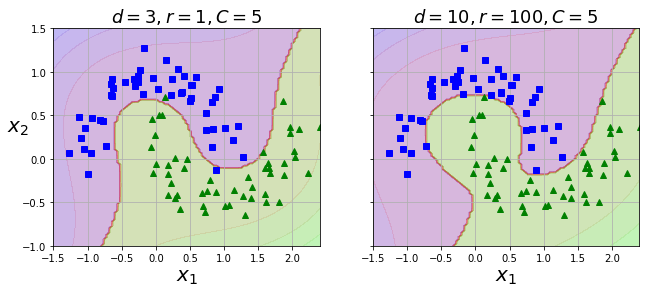

In [34]:
fig, axes = plt.subplots(ncols=2, figsize=(10.5, 4), sharey=True)

plt.sca(axes[0])
plot_predictions(poly_kernel_svm_clf, [-1.5, 2.45, -1, 1.5])
plot_dataset(X, y, [-1.5, 2.4, -1, 1.5])
plt.title(r"$d=3, r=1, C=5$", fontsize=18)

plt.sca(axes[1])
plot_predictions(poly10_kernel_svm_clf, [-1.5, 2.45, -1, 1.5])
plot_dataset(X, y, [-1.5, 2.4, -1, 1.5])
plt.title(r"$d=10, r=100, C=5$", fontsize=18)
plt.ylabel("")

plt.show()

In [37]:
'''
가우시안 RBF커널을 사용한 SVC 모델 (유사도 특성을 추가하는 것과 비슷한 결과를 얻음)
'''
rbf_kernel_svm_clf = Pipeline([
    ("scaler", StandardScaler()),
    ("svm_clf", SVC(kernel="rbf", gamma=5, C=0.001))  # gamma가 클수록, C가 작을수록 과대적합 된다
])
rbf_kernel_svm_clf.fit(X, y)

Pipeline(steps=[('scaler', StandardScaler()),
                ('svm_clf', SVC(C=0.001, gamma=5))])

__5.3 SVM 회귀__

In [38]:
from sklearn.svm import LinearSVR

svm_reg = LinearSVR(epsilon=1.5)
svm_reg.fit(X, y)

LinearSVR(epsilon=1.5)

In [39]:
from sklearn.svm import SVR

svm_poly_reg = SVR(kernel="poly", degree=2, C=100, epsilon=0.1)
svm_poly_reg.fit(X, y)

SVR(C=100, degree=2, kernel='poly')

__5.4 SVM 이론__